In [2]:
import tensorflow as tf
import os
import numpy as np

### Загружаем данные датасета

In [3]:
_CIFAR_IMAGE_SIZE = 32
from numpy import loadtxt

def load_data(path, labels_number=1):
  with tf.io.gfile.GFile(path, 'rb') as f:
    data = f.read()
  offset = 0
  max_offset = len(data) - 1
  coarse_labels = []
  fine_labels = []
  images = []
  while offset < max_offset:
    labels = np.frombuffer(
        data, dtype=np.uint8, count=labels_number, offset=offset
    ).reshape((labels_number,))
    # 1 байт под названия, 1024 * 3 = 3072 байтов под изображение.
    offset += labels_number
    img = (
        np.frombuffer(data, dtype=np.uint8, count=3072, offset=offset)
        .reshape((3, _CIFAR_IMAGE_SIZE, _CIFAR_IMAGE_SIZE))
        .transpose((1, 2, 0))
    )
    offset += 3072
    coarse_labels.append(labels[0])
    fine_labels.append(labels[1])
    images.append(img)
  return [np.array(coarse_labels), np.array(fine_labels), np.array(images)]

def load_labels(path):
    return loadtxt(path, comments="#", delimiter=",", unpack=False, dtype='str')

def load_cifar100():
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-binary.tar.gz"
    dataset = tf.keras.utils.get_file("cifar.tar.gz", url,untar=True, cache_dir='.', cache_subdir='')
    dataset_dir = os.path.join(os.path.dirname(dataset), 'cifar-100-binary')
    CY_train, FY_train, X_train = load_data(os.path.join(dataset_dir, 'train.bin'), labels_number=2)
    CY_test, FY_test, X_test = load_data(os.path.join(dataset_dir, 'test.bin'), labels_number=2)
    C_label = load_labels(os.path.join(dataset_dir, 'coarse_label_names.txt'))
    F_label = load_labels(os.path.join(dataset_dir, 'fine_label_names.txt'))
    
    return X_train, CY_train, FY_train, X_test, CY_test, FY_test, C_label, F_label

In [4]:
X_train, CY_train, FY_train, X_test, CY_test, FY_test, C_label, F_label = load_cifar100()

In [5]:
print(X_train.shape,CY_train.shape, FY_train.shape)

(50000, 32, 32, 3) (50000,) (50000,)


In [6]:
# Нормализация значений rgb
X_train, X_test = X_train / 255.0, X_test / 255.0

#### Предпросмотр датасета

In [7]:
def preview_images(classnames, label, images):
    plt.figure(figsize=(12,12))
    for i in range(120):
        plt.subplot(10,12,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(classnames[label[i]], labelpad=2, fontsize=6)
    plt.show()

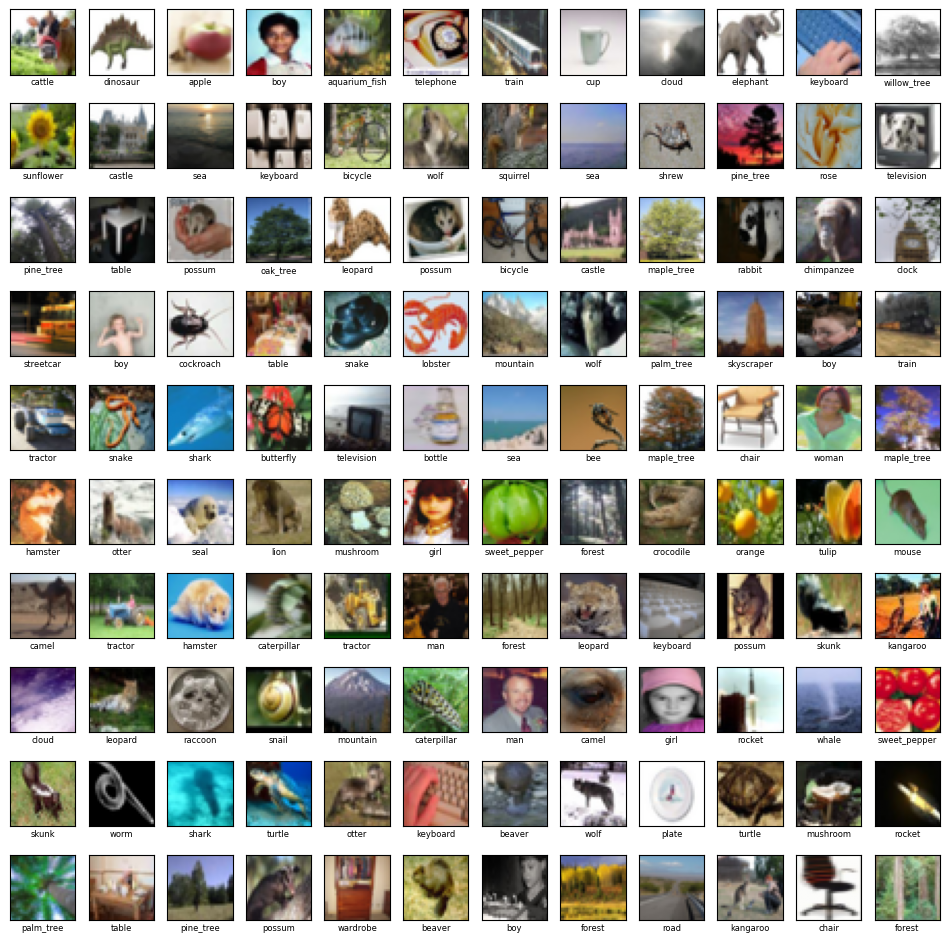

In [8]:
import matplotlib.pyplot as plt

# Вывод изображений с узкими классами
preview_images(F_label, FY_train, X_train)

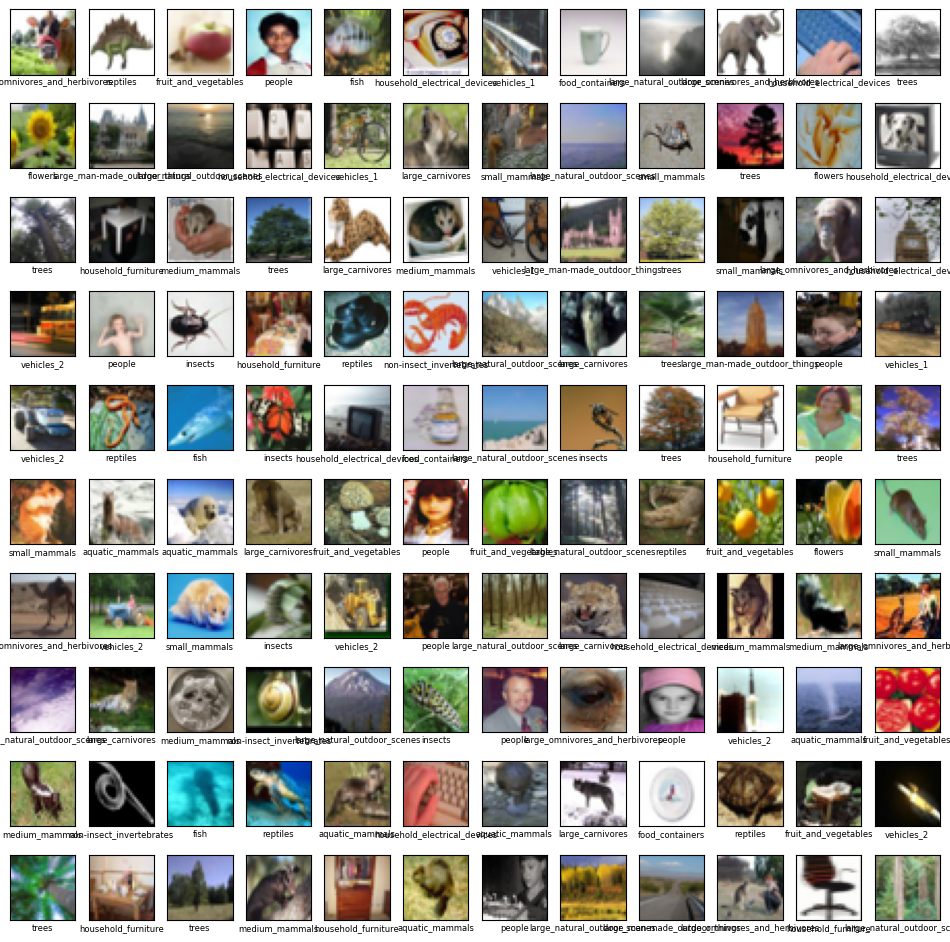

In [9]:
# Вывод изображений с широкими классами
preview_images(C_label, CY_train, X_train)

#### Построение модели

In [10]:
from tensorflow.keras import layers, models

def getModel():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(100, activation='softmax'))
    return model

In [12]:
model = getModel()

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 2, 2, 128)        

_**Какие элементы сети зависят от количества цветов, какие — от количества классов?**_

В качестве входных данных сверточная нейровнная сеть (CNN) принимает тензор формы (высота, ширина, кол-во цветов). В нашем случае, это (32, 32, 3).

CIFAR100 имеет 100 выходных классов, поэтому используется последний плотный слой со 100 выходными данными.

_**Объяснение места в модели каждого слоя, обоснование выбора гиперпараметров.**_

В сверточной нейронной сети выходы промежуточных слоев образуют матрицу (изображение) или набор матриц (несколько слоёв изображения). Так, например, на вход сверточной нейронной сети можно подавать три слоя изображения (R-, G-, B-каналы изображения). Основными видами слоев в сверточной нейронной сети являются сверточные слои (англ. convolutional layer), пулинговые слои (англ. pooling layer) и полносвязные слои (англ. fully-connected layer).
 
_Сверточный слой_ нейронной сети представляет из себя применение операции свертки к выходам с предыдущего слоя, где веса ядра свертки являются обучаемыми параметрами. Еще один обучаемый вес используется в качестве константного сдвига (англ. bias). При этом есть несколько важных деталей:
- В одном сверточном слое может быть несколько сверток. В этом случае для каждой свертки на выходе получится своё изображение.
- Ядра свертки могут быть трёхмерными.
- Применение операции свертки уменьшает изображение. Также пиксели, которые находятся на границе изображения участвуют в меньшем количестве сверток, чем внутренние. В связи с этим в сверточных слоях используется дополнение изображения (англ. padding). Выходы с предыдущего слоя дополняются пикселями так, чтобы после свертки сохранился размер изображения. Такие свертки называют одинаковыми (англ. same convolution), а свертки без дополнения изображения называются правильными (англ. valid convolution).
- Еще одним параметром сверточного слоя является сдвиг (англ. stride). Хоть обычно свертка применяется подряд для каждого пикселя, иногда используется сдвиг, отличный от единицы — скалярное произведение считается не со всеми возможными положениями ядра, а только с положениями, кратными некоторому сдвигу S.
- Высота и ширина окна свертки подбирается экспериментально и не должна быть больше начального размера изображения.

_Пулинговый слой_ призван снижать размерность изображения. Чаще всего используется функция максимума (англ. max pooling) или (взвешенного) среднего (англ. (weighted) average pooling). Обучаемых параметров у этого слоя нет.

|  |  |  |
| --- | --- | --- |
| <td colspan=2> **model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))** |
| <td colspan=2> Сверточный 2D-слой. Число выходных фильтров в свертке (размерность выхода) filters W2=32. Высота и ширина окна свертки kernel_size = (F, F) = (3,3). Функция активации = 'relu' _(f(x) = max{0, z})_. input_shape = (W1, H1, D) |
| _Layer (type)_ | _Output Shape_ | _Param_ |
| conv2d (Conv2D) | (None, 30, 30, 32) | 896 |
|  | None - кол-во пакетов (единый пакет - None) <br/> 30, 30 = (начальная ширина W1/высота H1 - размер ядра F + 2\*отступ)/шаг + 1 = (32 - 3 +2*0)/1+1 - итоговая ширина, высота <br/> 32 - число выходных фильтров в свертке (размерность выхода) | 896 = W2 \* (D \* F \* F + 1) = 32 \* (3\*3\*3+1) |
|  |  |  |
| <td colspan=2> **model.add(layers.MaxPooling2D((2, 2)))** |
| <td colspan=2> Cлой подвыборки, снижающий размерность поступивших на него данных. Размер окна подвыборки pool_size=(2, 2)=(F, F). Шаг подвыборки strides = None, что означает, что strides = pool_size=(2, 2) = S = F.  |
| _Layer (type)_ | _Output Shape_ | _Param_ |
| max_pooling2d (MaxPooling2D) | (None, 15, 15, 32)| 0 |
|  | None - кол-во пакетов (единый пакет - None) <br/> 15, 15 = (W1/H1 - F)/S+1 = (30 - 2)/2+1  <br/> 32 - число выходных фильтров в свертке (размерность выхода) | 0 |
|  |  |  |
| <td colspan=2> **model.add(layers.Conv2D(64, (3, 3), activation='relu'))** |
| <td colspan=2> Сверточный 2D-слой. Число выходных фильтров в свертке (размерность выхода) filters W2=64. Высота и ширина окна свертки kernel_size = (F, F) = (3,3). Функция активации = 'relu'. input_shape = (W1=15, H1=15, D=32) |
| _Layer (type)_ | _Output Shape_ | _Param_ |
| conv2d_1 (Conv2D) | (None, 13, 13, 64) | 18496 |
|  | None - кол-во пакетов (единый пакет - None) <br/> 13, 13 = (начальная ширина W1/высота H1 - размер ядра F + 2\*отступ)/шаг + 1 = (15 - 3 +2*0)/1+1 - итоговая ширина, высота <br/> 64 - число выходных фильтров в свертке (размерность выхода) | 18496 = W2 \* (D \* F \* F + 1) = 64 \* (32\*3\*3+1) |
|  |  |  |
| <td colspan=2> **model.add(layers.MaxPooling2D((2, 2)))** |
| <td colspan=2> Cлой подвыборки, снижающий размерность поступивших на него данных. Размер окна подвыборки pool_size=(2, 2)=(F, F). Шаг подвыборки strides = None, что означает, что strides = pool_size=(2, 2) = S = F.  |
| _Layer (type)_ | _Output Shape_ | _Param_ |
| max_pooling2d_1 (MaxPooling2D) | (None, 6, 6, 64)| 0 |
|  | None - кол-во пакетов (единый пакет - None) <br/> 6, 6 = (W1/H1 - F)/S+1 = (13 - 2)/2+1  <br/> 64 - число выходных фильтров в свертке (размерность выхода) | 0 |
|  |  |  |
| <td colspan=2> **model.add(layers.Conv2D(128, (3, 3), activation='relu'))** |
| <td colspan=2> Сверточный 2D-слой. Число выходных фильтров в свертке (размерность выхода) filters W2=128. Высота и ширина окна свертки kernel_size = (F, F) = (3,3). Функция активации = 'relu'. input_shape = (W1=6, H1=6, D=64) |
| _Layer (type)_ | _Output Shape_ | _Param_ |
| conv2d_2 (Conv2D) | (None, 4, 4, 128) | 73856 |
|  | None - кол-во пакетов (единый пакет - None) <br/> 4, 4 = (начальная ширина W1/высота H1 - размер ядра F + 2\*отступ)/шаг + 1 = (6 - 3 +2*0)/1+1 - итоговая ширина, высота <br/> 128 - число выходных фильтров в свертке (размерность выхода) | 73856 = W2 \* (D \* F \* F + 1) = 128 \* (64\*3\*3+1) |
|  |  |  |
| <td colspan=2> **model.add(layers.MaxPooling2D((2, 2)))** |
| <td colspan=2> Cлой подвыборки, снижающий размерность поступивших на него данных. Размер окна подвыборки pool_size=(2, 2)=(F, F). Шаг подвыборки strides = None, что означает, что strides = pool_size=(2, 2) = S = F.  |
| _Layer (type)_ | _Output Shape_ | _Param_ |
| max_pooling2d_2 (MaxPooling2D) | (None, 2, 2, 128)| 0 |
|  | None - кол-во пакетов (единый пакет - None) <br/> 2, 2 = (W1/H1 - F)/S+1 = (4 - 2)/2+1  <br/> 128 - число выходных фильтров в свертке (размерность выхода) | 0 |
|  |  |  |
| <td colspan=2> **model.add(layers.Flatten())** |
| <td colspan=2> Cлой слой, преобразующий 2D-данные в 1D-данные.  |
| _Layer (type)_ | _Output Shape_ | _Param_ |
| flatten (Flatten) | (None, 512) | 0 |
| | None - кол-во пакетов (единый пакет - None) <br/> 512=W1\*H1\*D=2\*2\*128 - одномерные данные | 0 |
|  |  |  |
| <td colspan=2> **model.add(layers.Dense(256, activation='relu'))** |
| <td colspan=2> Полносвязный слой. Размер выхода слоя units = U = 256. W=512 - размер входного слоя. Функция активации = 'relu'. |
| _Layer (type)_ | _Output Shape_ | _Param_ |
| dense (Dense) | (None, 256) | 131328 |
|  | None - кол-во пакетов (единый пакет - None) <br/> 256 - размер выхода | 131328 = W * U + U = 512 * 256 + 256 |
|  |  |  |
| <td colspan=2> **model.add(layers.Dense(128, activation='relu'))** |
| <td colspan=2> Полносвязный слой. Размер выхода слоя units = U = 128. W=256 - размер входного слоя. Функция активации = 'relu'. |
| _Layer (type)_ | _Output Shape_ | _Param_ |
| dense_1 (Dense) | (None, 128) | 32896 |
|  | None - кол-во пакетов (единый пакет - None) <br/> 128 - размер выхода | 32896 = W * U + U = 256 * 128 + 128 |
|  |  |  |
| <td colspan=2> **model.add(layers.Dense(100, activation='softmax'))** |
| <td colspan=2> Полносвязный слой. Размер выхода слоя units = U = 100. W=128 - размер входного слоя. Функция активации = 'softmax' нормализованная экспоненциальная функция преобразует вектор из действительных чисел в распределение вероятностей возможных результатов. |
| _Layer (type)_ | _Output Shape_ | _Param_ |
| dense_2 (Dense) | (None, 100) | 12900 |
|  | None - кол-во пакетов (единый пакет - None) <br/> 100 - размер выхода | 12900 = W * U + U = 128 * 100 + 100 |

При компиляции модели применяется функция потерь - категориальная перекрестная энтропия (tf.keras.losses.SparseCategoricalCrossentropy). В качестве оптимизатора - вариант стохастической оптимизации ('adam'). Для оценки эффективности модели используется точность ('accuracy').

In [14]:
def getCompiledModel():
    model = getModel()
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])
    return model

#### Обучение на 20 широких классах

In [15]:
model = getCompiledModel()

In [16]:
his = model.fit(X_train, CY_train, epochs=20)

Epoch 1/20


2023-10-27 01:40:02.493798: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.
/home/ceedy/jupyter-venv/lib/python3.10/site-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 21s 13ms/step - loss: 2.5177 - accuracy: 0.2178
Epoch 2/20
1563/1563 [==============================] - 20s 13ms/step - loss: 2.0627 - accuracy: 0.3563
Epoch 3/20
1563/1563 [==============================] - 20s 13ms/step - loss: 1.8490 - accuracy: 0.4204
Epoch 4/20
1563/1563 [==============================] - 20s 13ms/step - loss: 1.6961 - accuracy: 0.4656
Epoch 5/20
1563/1563 [==============================] - 21s 14ms/step - loss: 1.5850 - accuracy: 0.5009
Epoch 6/20
1563/1563 [==============================] - 21s 14ms/step - loss: 1.4792 - accuracy: 0.5305
Epoch 7/20
1563/1563 [==============================] - 21s 14ms/step - loss: 1.3869 - accuracy: 0.5601
Epoch 8/20
1563/1563 [==============================] - 21s 14ms/step - loss: 1.3106 - accuracy: 0.5812
Epoch 9/20
1563/1563 [==============================] - 22s 14ms/step - loss: 1.2308 - accuracy: 0.6078
Epoch 10/20
1563/1563 [==============================] - 21s 14ms/step - lo

##### Экспорт обученной модели в файл

In [17]:
model.save('./coarse_model.keras')

##### Точность на тестовых данных

In [18]:
С_test_loss, С_test_acc = model.evaluate(X_test, CY_test)

print('\nТочность на тестовых данных:', С_test_acc)

313/313 [==============================] - 2s 5ms/step - loss: 2.2427 - accuracy: 0.4920

Точность на тестовых данных: 0.492000013589859


##### Предсказания

In [19]:
!pip install scikit-learn

In [20]:
# Получаем набор вероятностей определения каждой категории
С_predictions = model.predict(X_test)

# Находим максимальные вероятности в наборе предсказаний
С_predictions = np.argmax(С_predictions, axis=-1)

# Отображаем оценку модели
from sklearn.metrics import classification_report

print(classification_report(CY_test, С_predictions, target_names=C_label))

313/313 [==============================] - 2s 5ms/step
                                precision    recall  f1-score   support

               aquatic_mammals       0.41      0.38      0.39       500
                          fish       0.53      0.46      0.49       500
                       flowers       0.64      0.73      0.68       500
               food_containers       0.48      0.48      0.48       500
          fruit_and_vegetables       0.58      0.60      0.59       500
  household_electrical_devices       0.38      0.47      0.42       500
           household_furniture       0.58      0.48      0.52       500
                       insects       0.52      0.48      0.50       500
              large_carnivores       0.38      0.42      0.40       500
 large_man-made_outdoor_things       0.58      0.62      0.60       500
  large_natural_outdoor_scenes       0.60      0.71      0.65       500
large_omnivores_and_herbivores       0.40      0.40      0.40       500
        

#### Обучение на 100 узких классах

In [21]:
tf.keras.backend.clear_session()

model = model = getCompiledModel()

his = model.fit(X_train, FY_train, epochs=20)

Epoch 1/20


2023-10-27 01:47:43.252479: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.
/home/ceedy/jupyter-venv/lib/python3.10/site-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 23s 14ms/step - loss: 3.9799 - accuracy: 0.0845
Epoch 2/20
1563/1563 [==============================] - 22s 14ms/step - loss: 3.2887 - accuracy: 0.1976
Epoch 3/20
1563/1563 [==============================] - 24s 15ms/step - loss: 2.9562 - accuracy: 0.2641
Epoch 4/20
1563/1563 [==============================] - 23s 15ms/step - loss: 2.7260 - accuracy: 0.3083
Epoch 5/20
1563/1563 [==============================] - 23s 15ms/step - loss: 2.5535 - accuracy: 0.3425
Epoch 6/20
1563/1563 [==============================] - 23s 14ms/step - loss: 2.4091 - accuracy: 0.3754
Epoch 7/20
1563/1563 [==============================] - 23s 15ms/step - loss: 2.2845 - accuracy: 0.4014
Epoch 8/20
1563/1563 [==============================] - 22s 14ms/step - loss: 2.1817 - accuracy: 0.4218
Epoch 9/20
1563/1563 [==============================] - 23s 15ms/step - loss: 2.0871 - accuracy: 0.4434
Epoch 10/20
1563/1563 [==============================] - 23s 15ms/step - lo

##### Экспорт обученной модели в файл

In [22]:
model.save('./fine_model.keras')

##### Точность на тестовых данных

In [23]:
F_test_loss, F_test_acc = model.evaluate(X_test, FY_test)

print('\nТочность на тестовых данных:', F_test_acc)

313/313 [==============================] - 2s 5ms/step - loss: 3.0371 - accuracy: 0.3590

Точность на тестовых данных: 0.35899999737739563


##### Предсказания

In [24]:
# Получаем набор вероятностей определения каждой категории
F_predictions = model.predict(X_test)

# Находим максимальные вероятности в наборе предсказаний
F_predictions = np.argmax(F_predictions, axis=-1)

# Отображаем оценку модели
print(classification_report(FY_test, F_predictions, target_names=F_label))
F_report = classification_report(FY_test, F_predictions, target_names=F_label, output_dict = True)


313/313 [==============================] - 1s 5ms/step
               precision    recall  f1-score   support

        apple       0.66      0.58      0.62       100
aquarium_fish       0.34      0.55      0.42       100
         baby       0.23      0.20      0.21       100
         bear       0.17      0.11      0.13       100
       beaver       0.17      0.14      0.15       100
          bed       0.36      0.28      0.31       100
          bee       0.38      0.38      0.38       100
       beetle       0.36      0.34      0.35       100
      bicycle       0.33      0.44      0.38       100
       bottle       0.51      0.42      0.46       100
         bowl       0.20      0.11      0.14       100
          boy       0.27      0.21      0.23       100
       bridge       0.34      0.38      0.36       100
          bus       0.26      0.38      0.31       100
    butterfly       0.27      0.35      0.31       100
        camel       0.19      0.28      0.23       100
         

### Сравнение
#### Обобщение предсказаний по узким меткам до метки их широкого класса

In [25]:
# Определение по узкой категории широкой
def init_fine_map():
    map = {
        "aquatic_mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
        "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
        "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
        "food_containers": ["bottle", "bowl", "can", "cup", "plate"],
        "fruit_and_vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
        "household_electrical_devices": ["clock", "keyboard", "lamp", "telephone", "television"],
        "household_furniture": ["bed", "chair", "couch", "table", "wardrobe"],
        "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
        "large_carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
        "large_man-made_outdoor_things": ["bridge", "castle", "house", "road", "skyscraper"],
        "large_natural_outdoor_scenes": ["cloud", "forest", "mountain", "plain", "sea"],
        "large_omnivores_and_herbivores": ["camel", "cattle", "chimpanzee", "elephant", "kangaroo"],
        "medium_mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
        "non-insect_invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
        "people": ["baby", "boy", "girl", "man", "woman"],
        "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
        "small_mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
        "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
        "vehicles_1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
        "vehicles_2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"],
    }
    dict = {}
    for label in F_label:
        for key in map:
            if label in map[key]:
                dict.update({label: key})
                break
    return dict

fine_to_coarse = init_fine_map()

In [26]:
FC = lambda i: fine_to_coarse[F_label[i]]
CF_predictions = np.array([FC(i) for i in F_predictions])
C_index = lambda i: np.where(C_label == i)[0][0]
CF_predictions = np.array([C_index(i) for i in CF_predictions])

##### Оценка обобщенных предсказаний по узким меткам до метки их широкого класса

In [27]:
print(classification_report(CY_test, CF_predictions, target_names=C_label))
CF_report = classification_report(CY_test, CF_predictions, target_names=C_label, output_dict = True)

                                precision    recall  f1-score   support

               aquatic_mammals       0.47      0.32      0.38       500
                          fish       0.45      0.51      0.48       500
                       flowers       0.61      0.70      0.65       500
               food_containers       0.53      0.42      0.47       500
          fruit_and_vegetables       0.57      0.57      0.57       500
  household_electrical_devices       0.48      0.48      0.48       500
           household_furniture       0.56      0.57      0.56       500
                       insects       0.53      0.47      0.50       500
              large_carnivores       0.40      0.36      0.38       500
 large_man-made_outdoor_things       0.59      0.60      0.60       500
  large_natural_outdoor_scenes       0.73      0.65      0.69       500
large_omnivores_and_herbivores       0.35      0.47      0.40       500
                medium_mammals       0.33      0.51      0.40  

##### Оценка предсказаний при обучении на широких метках

In [28]:
print(classification_report(CY_test, С_predictions, target_names=C_label))
C_report = classification_report(CY_test, С_predictions, target_names=C_label, output_dict = True)

                                precision    recall  f1-score   support

               aquatic_mammals       0.41      0.38      0.39       500
                          fish       0.53      0.46      0.49       500
                       flowers       0.64      0.73      0.68       500
               food_containers       0.48      0.48      0.48       500
          fruit_and_vegetables       0.58      0.60      0.59       500
  household_electrical_devices       0.38      0.47      0.42       500
           household_furniture       0.58      0.48      0.52       500
                       insects       0.52      0.48      0.50       500
              large_carnivores       0.38      0.42      0.40       500
 large_man-made_outdoor_things       0.58      0.62      0.60       500
  large_natural_outdoor_scenes       0.60      0.71      0.65       500
large_omnivores_and_herbivores       0.40      0.40      0.40       500
                medium_mammals       0.39      0.36      0.38  

Общая точность предсказания в обоих случаях одинакова и составляет 0.49. Нельзя точно сказать, какой из методов дает лучший результат. Например, для широкого класса insects точность во первом случае 0.45, что хуже, чем 0.59 во втором случае. Однако для класса large_natural_outdoor_scenes в первом случае точность 0.75, что лучше, чем 0.68 в первом случае.

#### Исследование с помощью графиков метрики предсказания для каких узких классов более всего отличаются от метрик их более широких классов

In [29]:
# Точность распознавания узкого класса
F_precision =  lambda i: F_report[i]['precision']
F_precisions = np.array([F_precision(i) for i in F_label])

#Точность распознавания широкого класса по узкому
CF_precision =  lambda i: CF_report[fine_to_coarse[i]]['precision']
CF_precisions = np.array([CF_precision(i) for i in F_label])

# Точность распознавания соответствующего широкого класса
C_precision =  lambda i: C_report[fine_to_coarse[i]]['precision']
C_precisions = np.array([C_precision(i) for i in F_label])

In [30]:
!pip install pandas

<Axes: >

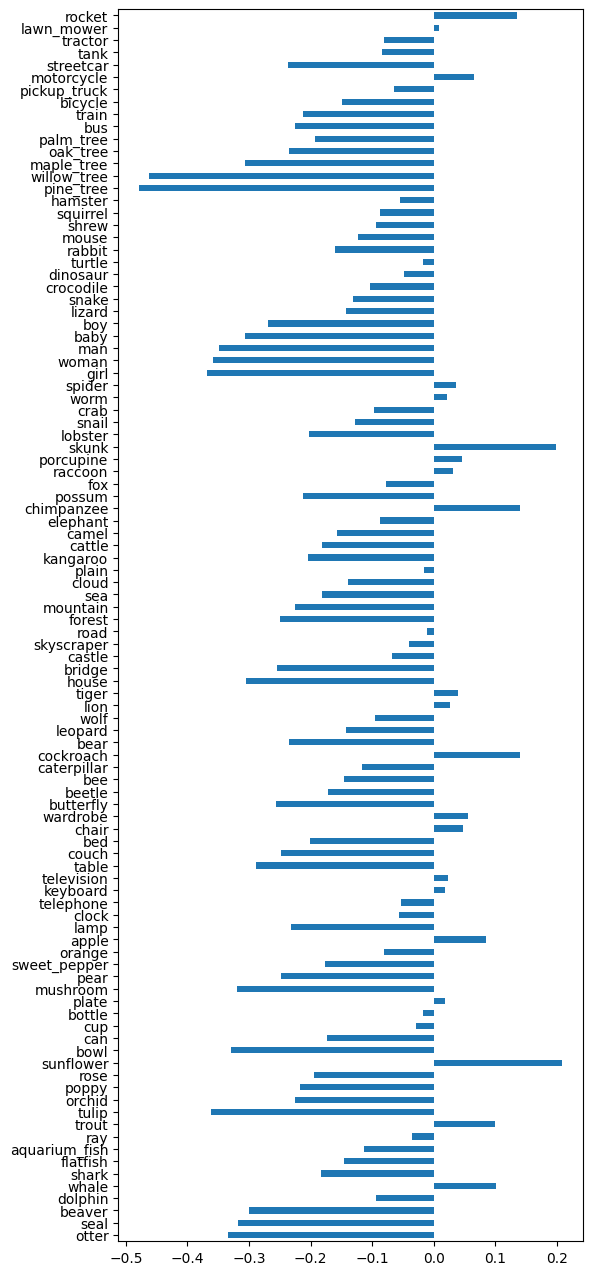

In [31]:
import pandas as pd

df = pd.DataFrame(
    {
     'label': F_label,
     'c_label': np.array([fine_to_coarse[i] for i in F_label]),
     'F_CF': F_precisions - CF_precisions,
     'F_C': F_precisions - C_precisions,
     'CF_C': CF_precisions - C_precisions,
    })

# График различия точности распознавания узкого класса и точности распознавания широкого класса по узкому
df.sort_values(by=['c_label', 'F_CF'],ascending=True).plot.barh(y='F_CF', x='label', legend=False, figsize=(6, 16), ylabel='')

График показывает различия точности распознавания узкого класса и точности распознавания широкого класса по узкому и позволяет сделать вывод, насколько точно определяется узкий класс в рамках широкого. Наибольший разброс имеют элементы широкого класса деревьев (trees) и людей (people), это говорит о том, что конкретный вид деревьев и людей между собой данная сеть определяет плохо. Наименьшее отклонение имеют следующие узкие классы lawn_mover, turtle, worm, plain, road, keyboard, telephone, plate, bottle, такие сеть определяет хорошо. 

<Axes: >

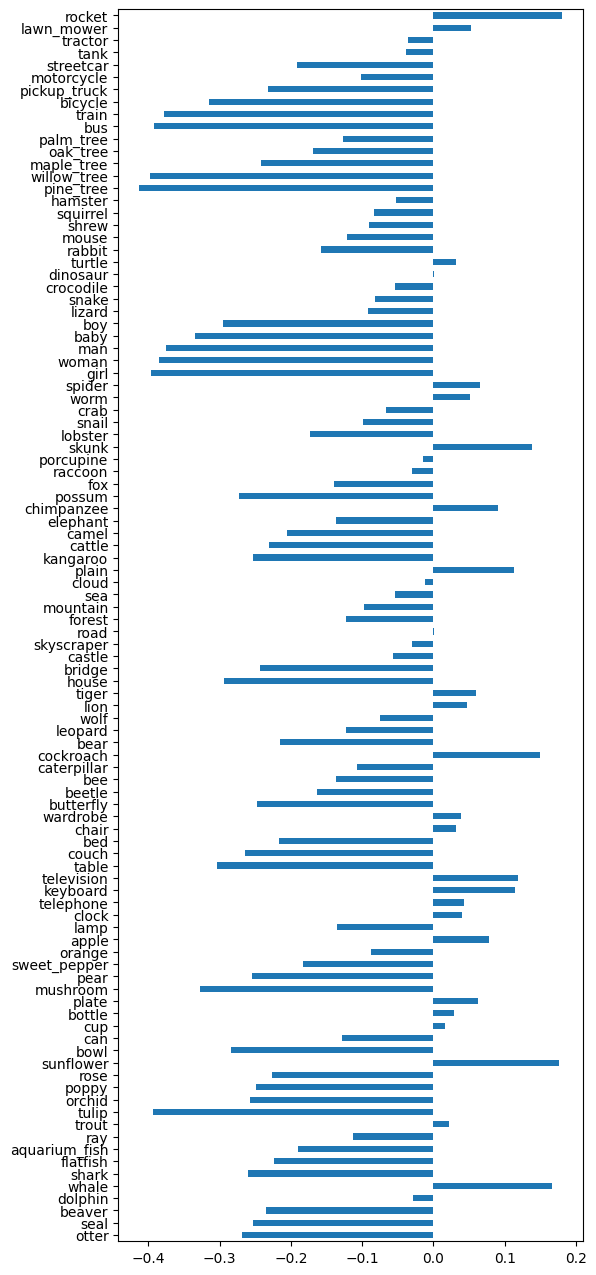

In [32]:
# График различия точности распознавания узкого класса и точности распознавания широкого класса
df.sort_values(by=['c_label', 'F_C'],ascending=True).plot.barh(y='F_C', x='label', legend=False, figsize=(6, 16), ylabel='')

График показывает различия точности распознавания узкого класса и точности распознавания широкого класса и позволяет сделать вывод о том, что модель определяет лучше широкие классы или узкие. Например, изображение сосны (pine_tree) в случае определения по широкому классу определяется лучше, чем по узкому. А изображения динозавра (dinosaur), дикообраза (porcupine), облака (cloud), дороги (road) определяются с примерно одинаковой точностью, как в случае распознавания по узкому классу, так и по широкому.

<Axes: >

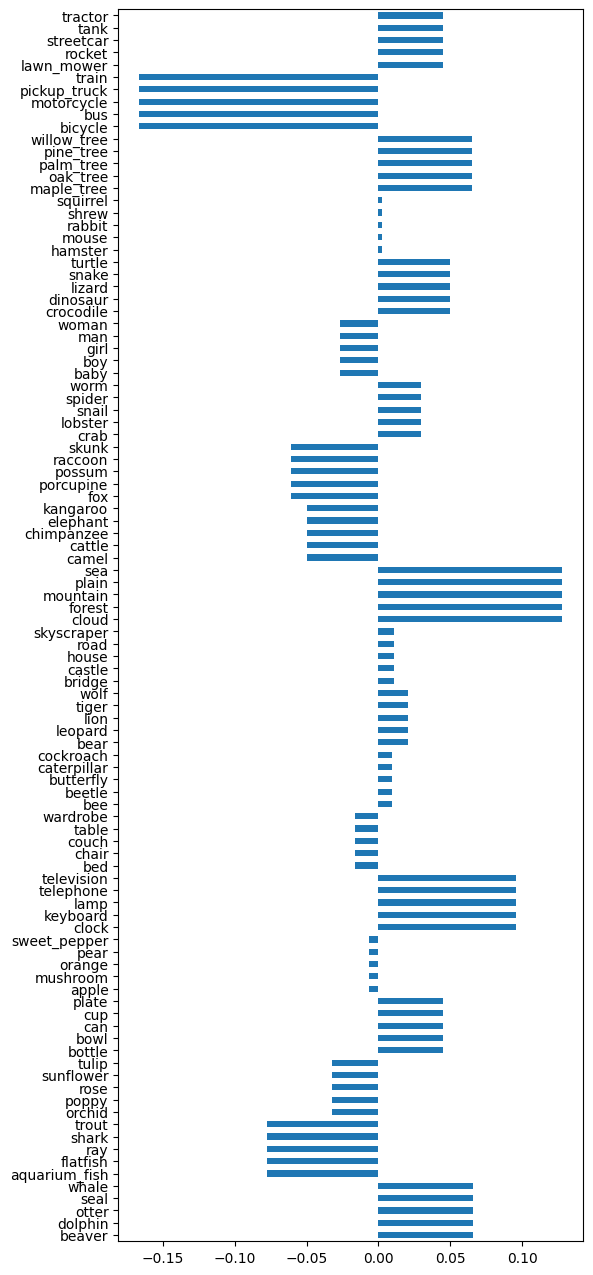

In [33]:
# График различия точности распознавания широкого класса по узкому и точности распознавания широкого класса
df.sort_values(by=['c_label', 'CF_C'],ascending=True).plot.barh(y='CF_C', x='label', legend=False, figsize=(6, 16), ylabel='')

График различия точности распознавания широкого класса по узкому и точности распознавания широкого класса позволяет сделать вывод о том, какие категории лучше определяются при обучении на узких классах, а какие на широких. На узких классах лучше определяются (имеют положительное значение на графике) транспортные средства (vehicles_2), деревья (trees), рептилии (reptiles), беспозвоночные ненасекомые(non-insect invertebrates), природа (large natural outdoor scenes), контейнеры для еды (food containers), водные млекопитающие (aquatic mammals) и пр.. Остальные классы лучше определяются при обучении на широких классах.